In [1]:
!pip install -q pytorch-lightning

In [2]:
from os import makedirs
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import datasets, transforms, utils

path = 'output'
makedirs(path, exist_ok=True)

img_shape = (1, 28, 28)

losses = []

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 28*28)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = torch.tanh(self.fc4(x))
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = torch.sigmoid(self.fc4(x))
        return out

In [4]:
class GAN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.G = Generator()
        self.D = Discriminator()
    
    def forward(self, x):
        return self.D(x)
    
    def loss_function(self, y_hat, y):
        return nn.BCELoss()(y_hat, y)
    
    def configure_optimizers(self):
        optimizer_G = torch.optim.Adam(self.G.parameters(), lr=0.002)
        optimizer_D = torch.optim.Adam(self.D.parameters(), lr=0.002)
        
        return [optimizer_G, optimizer_D], []

    def prepare_data(self):
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])])
        
        train_data = datasets.MNIST('data/', train=True, download=True, transform=transform)
        return train_data

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.prepare_data(), batch_size=32, shuffle=True)
        return train_loader
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_images, _ = batch
        
        real = torch.ones(real_images.size(0), 1)
        fake = torch.zeros(real_images.size(0), 1)

        criterion = self.loss_function
        
        ## Generator
        if optimizer_idx == 0:
            gen_input = torch.randn(real_images.shape[0], 100)
            self.gen_images = self.G(gen_input)
            self.g_loss = criterion(self(self.gen_images), real)
            return self.g_loss

        ## Discriminator
        if optimizer_idx == 1:
            real_loss = criterion(self(real_images), real)
            fake_loss = criterion(self(self.gen_images.detach()), fake)
            self.d_loss = real_loss + fake_loss            
            return self.d_loss
    
    def on_epoch_end(self):
        losses.append((self.d_loss.item(), self.g_loss.item()))
        # Saving 5x5 grid
        utils.save_image(self.gen_images.view(self.gen_images.shape[0], *img_shape).data[:25]
                                     , path+'/%d.png' % self.current_epoch, nrow=5, padding=0, normalize=True)

In [7]:
def main():
    gan = GAN()
    trainer = pl.Trainer(max_epochs=100)
    trainer.fit(gan)
    
gan = main()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type          | Params
---------------------------------------
0 | G    | Generator     | 114 K 
1 | D    | Discriminator | 110 K 
---------------------------------------
225 K     Trainable params
0         Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

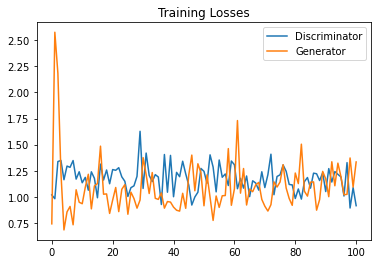

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()